# NDSSL Node Classification - Household

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import itertools
from tqdm.auto import tqdm, trange

from torch_geometric.data import Data, InMemoryDataset, DataLoader
from torch_geometric.nn import GCNConv, SAGEConv
from torch_geometric.data import GraphSAINTRandomWalkSampler
from torch_geometric.utils import get_laplacian, degree

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.style as style 
style.use('seaborn-paper')

fontsize = 12
plt.rcParams.update({
    'font.size': fontsize, 
    'axes.labelsize': fontsize, 
    'legend.fontsize': fontsize,
    'xtick.labelsize': fontsize,
    'ytick.labelsize': fontsize,
    'axes.titlesize': fontsize
                    })

In [2]:
#from imports import *
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## Data processing

Convert the node attribute data into an (x,y) format

In [3]:
node_attributes = pd.read_csv('../../data/NDSSL data/raw/node_attributes.csv')

## one-hot encode gender
gender_index = torch.LongTensor(node_attributes['gender'].values - 1).type(torch.int64).reshape((len(node_attributes), 1))
gender_onehot = torch.LongTensor(len(node_attributes), 2)
gender_onehot.zero_()
gender_onehot = gender_onehot.scatter_(1, gender_index, 1).type(torch.float32);

## one-hot encode worker
worker_index = torch.LongTensor(node_attributes['worker'].values - 1).type(torch.int64).reshape((len(node_attributes), 1))
worker_onehot = torch.LongTensor(len(node_attributes), 2)
worker_onehot.zero_()
worker_onehot = worker_onehot.scatter_(1, worker_index, 1).type(torch.float32);

## map the 117 distinct zipcodes to the integers 0, ..., 116
zipcode_original = node_attributes['zipcode'].values
zipcode_dict = {i: j for j, i in enumerate(set(zipcode_original))} 
zipcode_index = torch.LongTensor(np.asarray([zipcode_dict[i] for i in zipcode_original])).type(torch.int64).reshape((len(node_attributes), 1))

## one-hot encode zipcode
zipcode_onehot = torch.LongTensor(len(node_attributes), len(zipcode_dict))
zipcode_onehot.zero_()
zipcode_onehot = zipcode_onehot.scatter_(1, zipcode_index, 1).type(torch.float32);

## one-hot encode household income
household_income_index = torch.LongTensor(node_attributes['household_income'].values - 1).type(torch.int64).reshape((len(node_attributes), 1))
household_income_onehot = torch.LongTensor(len(node_attributes), 14)
household_income_onehot.zero_()
household_income_onehot = household_income_onehot.scatter_(1, household_income_index, 1).type(torch.float32);

## one-hot encode relationship
relationship_index = torch.LongTensor(node_attributes['relationship'].values - 1).type(torch.int64).reshape((len(node_attributes), 1))
relationship_onehot = torch.LongTensor(len(node_attributes), 4)
relationship_onehot.zero_()
relationship_onehot = relationship_onehot.scatter_(1, relationship_index, 1).type(torch.float32);

age = torch.FloatTensor(node_attributes['age'].values).reshape(len(node_attributes), 1).type(torch.float32)
household_size = torch.FloatTensor(node_attributes['household_size'].values).reshape(len(node_attributes), 1).type(torch.float32)
household_workers = torch.FloatTensor(node_attributes['household_workers'].values).reshape(len(node_attributes), 1).type(torch.float32)
household_vehicles = torch.FloatTensor(node_attributes['household_vehicles'].values).reshape(len(node_attributes), 1).type(torch.float32)

In [4]:
x = torch.cat((gender_onehot, worker_onehot, age, relationship_onehot, zipcode_onehot, household_size, household_workers, household_vehicles), dim=1)
y = torch.LongTensor(node_attributes['household_income'].values - 1).type(torch.int64)#.reshape((len(node_attributes)), 1)

print(x.shape, x.dtype)
print(y.shape, y.dtype)

torch.Size([1601330, 129]) torch.float32
torch.Size([1601330]) torch.int64


Note that the household income is not evenly distributed

In [5]:
class_membership = {i:torch.sum(y == i).item()/len(node_attributes) for i in range(14)}
class_membership

{0: 0.02553377504949011,
 1: 0.04408210674876509,
 2: 0.05800241049627497,
 3: 0.06630238614151986,
 4: 0.07642022568739736,
 5: 0.08593856356903325,
 6: 0.09993630294817434,
 7: 0.08903536435338125,
 8: 0.07680865280735388,
 9: 0.0698057239919317,
 10: 0.059364403339723856,
 11: 0.045411626585400884,
 12: 0.20297065564249717,
 13: 0.0003878026390562845}

Note that this is the distribution of household income *by individual*, whereas earlier in the data analysis workflow we plotted the distribution of household income *by household*. 

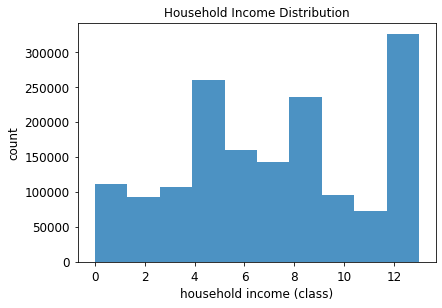

In [6]:
plt.hist(y.numpy(), alpha=0.8)
plt.title('Household Income Distribution')
plt.xlabel('household income (class)')
plt.ylabel('count')

plt.show()

Below we will train machine learning classifiers. Before we do so, let's see how good we can do with just a few simple (non-learned) guessing strategies. These will serve as good baselines for any model we train. 

There are at least 3 simple ways to guess
1. uniform random guessing (each class is equally likely)
2. weighted random guessing (pick each class according to it's frequency)
3. always pick the most popular class

The theoretical result for each of these strategies can be easily worked out. If we pick the classes randomly with weights $x_i$, and the true class weights are $w_i$, then the expected accuracy is:
$$ \mathbb{E} \text{acc} = \sum_{i=1}^C w_i x_i .$$
For strategy 1., $x_i = 1/C$, the expected accuracy is just $1/C$, as the weights sum to 1. For strategy 2., $x_i = w_i$. Strategy 3 is straightforwardly going to give just $\max(w)$.

In [7]:
print('uniform random guessing: %.2f' %np.mean(y.numpy() == np.random.choice(14, len(y))))
print('theoretical prediction: %.2f' % (1.0/14) )

class_probs = np.asarray(list(class_membership.values()))
print('\nweighted random guessing: %.2f' %np.mean(y.numpy() == np.random.choice(14, len(y), p=class_probs)))
print('theoretical prediction: %.2f' % np.sum(class_probs**2))

print('\nalways pick most popular class: %.2f' %np.mean(y.numpy() == np.ones(1)*np.argmax(class_probs)))
print('theoretical prediction: %.2f' % class_probs[np.argmax(class_probs)])

uniform random guessing: 0.07
theoretical prediction: 0.07

weighted random guessing: 0.10
theoretical prediction: 0.10

always pick most popular class: 0.20
theoretical prediction: 0.20


train/test split

In [8]:
## create a train/test split by household
household_ids = list(set(list(node_attributes['household_id'])))
np.random.shuffle(household_ids)

ntrain_households = int(0.8 * len(household_ids))
households_train = household_ids[:ntrain_households]
households_test = household_ids[ntrain_households:]
print('number of distinct households: %i' %len(household_ids))
print('number of training households: %i' %len(households_train))
print('number of testing households: %i' %len(households_test))

train_mask = torch.IntTensor(node_attributes['household_id'].isin(households_train)).type(torch.int64)
test_mask = torch.IntTensor(node_attributes['household_id'].isin(households_test)).type(torch.int64)
train_idx = np.arange(len(node_attributes))[train_mask == 1]
test_idx = np.arange(len(node_attributes))[test_mask == 1]

print('size of training set: %i' %torch.sum(train_mask).item())
print('size of testing set: %i' %torch.sum(test_mask).item())
print('percent train: %.2f' %(torch.sum(train_mask).item()/len(train_mask)))

number of distinct households: 632626
number of training households: 506100
number of testing households: 126526
size of training set: 1280463
size of testing set: 320867
percent train: 0.80


save

In [9]:
torch.save(x, '../../data/NDSSL data/raw/x.pt')
torch.save(y, '../../data/NDSSL data/raw/y.pt')
torch.save(train_mask, '../../data/NDSSL data/raw/train_mask.pt')
torch.save(test_mask, '../../data/NDSSL data/raw/test_mask.pt')
torch.save(train_idx, '../../data/NDSSL data/raw/train_idx.pt')
torch.save(test_idx, '../../data/NDSSL data/raw/test_idx.pt')

## Node classification: MLP 

In [24]:
full_set = torch.utils.data.TensorDataset(x, y)
train_set = torch.utils.data.Subset(full_set, train_idx)
test_set = torch.utils.data.Subset(full_set, test_idx)

In [25]:
class mlp(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(mlp, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.fc2 = torch.nn.Linear(self.hidden_size, self.hidden_size)
        self.fc3 = torch.nn.Linear(self.hidden_size, self.num_classes)
        self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = self.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.fc3(x)    
        x = x.log_softmax(dim=-1)
        return x

In [26]:
weight = torch.Tensor(class_membership[12]/np.asarray(list(class_membership.values()))).float().to(device)
weight = torch.ones(len(class_membership)).float().to(device)

def train():
    model.train()

    total_loss = total_examples = 0
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        out = model(x_batch)
        loss = F.nll_loss(out, y_batch, weight=weight)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x_batch.shape[0]
        total_examples += x_batch.shape[0]
    
    return total_loss/total_examples


@torch.no_grad()
def test():
    model.eval()
    
    ## train accuracy
    total_examples = correct = 0.0
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        out = model(x_batch)
        total_examples += out.shape[0]
        correct += torch.sum(torch.argmax(out, axis=1) == y_batch).cpu().item()
    train_accuracy = correct/total_examples
    
    ## test accuracy
    total_examples = correct = 0.0
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        out = model(x_batch)
        total_examples += x_batch.shape[0]
        correct += torch.sum(torch.argmax(out, axis=1) == y_batch).cpu().item()
    test_accuracy = correct/total_examples
    
    return train_accuracy, test_accuracy


**Question: why is this so slow, even with a GPU?**

In [15]:
model = mlp(x.shape[1], 1000, 14)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3)
print('number of trainable parameters %i' %sum(p.numel() for p in model.parameters() if p.requires_grad))

epochs = 50
batch_size = 1000
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

for epoch in range(0, epochs):
    loss = train()
    accs = test()
    print(f'Epoch: {epoch+1:02d}, Loss: {loss:.4f}, Train: {accs[0]:.4f}, 'f'Test: {accs[1]:.4f}')

number of trainable parameters 1145014
Epoch: 01, Loss: 2.5423, Train: 0.2036, Test: 0.2003
Epoch: 02, Loss: 2.4490, Train: 0.2208, Test: 0.2175
Epoch: 03, Loss: 2.4041, Train: 0.2218, Test: 0.2189
Epoch: 04, Loss: 2.3745, Train: 0.2275, Test: 0.2245
Epoch: 05, Loss: 2.3526, Train: 0.2284, Test: 0.2254
Epoch: 06, Loss: 2.3345, Train: 0.2288, Test: 0.2259
Epoch: 07, Loss: 2.3191, Train: 0.2292, Test: 0.2262
Epoch: 08, Loss: 2.3055, Train: 0.2296, Test: 0.2266
Epoch: 09, Loss: 2.2941, Train: 0.2303, Test: 0.2273
Epoch: 10, Loss: 2.2839, Train: 0.2322, Test: 0.2290
Epoch: 11, Loss: 2.2750, Train: 0.2340, Test: 0.2306
Epoch: 12, Loss: 2.2671, Train: 0.2353, Test: 0.2316
Epoch: 13, Loss: 2.2606, Train: 0.2362, Test: 0.2323
Epoch: 14, Loss: 2.2542, Train: 0.2385, Test: 0.2348
Epoch: 15, Loss: 2.2489, Train: 0.2397, Test: 0.2360
Epoch: 16, Loss: 2.2436, Train: 0.2411, Test: 0.2375
Epoch: 17, Loss: 2.2390, Train: 0.2428, Test: 0.2392
Epoch: 18, Loss: 2.2346, Train: 0.2448, Test: 0.2413
Epoch: 

## Node classification: Message Passing NNs

In [10]:
class NDSSLDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(NDSSLDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
        
    @property
    def raw_file_names(self):
        return ['edge_list.csv', 'x.pt', 'y.pt', 'train_mask.pt', 'test_mask.pt', 'edge_attributes.csv']

    @property
    def processed_file_names(self):
        return ['NDSSL_graph_full.pt']

    def process(self):
        data_list = []
        
        ## load the edge list
        edge_list = pd.read_csv(self.raw_paths[0], dtype=int) - 2000000 #the node id's start at 2000000, shift these to start at 0         
        
        ## format the edge list
        target_nodes = edge_list.iloc[:,0].values
        source_nodes = edge_list.iloc[:,1].values
        edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.int64)

        ## load the (x,y) formatted data
        x = torch.load(self.raw_paths[1], map_location=torch.device('cpu'))
        y = torch.load(self.raw_paths[2], map_location=torch.device('cpu'))
        train_mask = torch.load(self.raw_paths[3], map_location=torch.device('cpu')) == 1 
        test_mask = torch.load(self.raw_paths[4], map_location=torch.device('cpu')) == 1 

        ## set the edge weights to be the duration (in hours)
        edge_attributes = pd.read_csv(self.raw_paths[5])['duration'].values/3600
        duration =  torch.FloatTensor(edge_attributes)
        ## previous approaches used the degree:
        #row, col = data.edge_index
        #data.edge_attr = (1. / degree(col, data.num_nodes)[col]).double()
        
        ## build the data
        data = Data(edge_index=edge_index, x=x, y=y, train_mask=train_mask, test_mask=test_mask)
        data.edge_weight = duration
        data.train_mask = train_mask
        data.test_mask = test_mask
        #data.train_mask = torch.cat((torch.ones(n_train, dtype=torch.bool), torch.zeros(n_val, dtype=torch.bool), torch.zeros(n_test, dtype=torch.bool)), dim=0)
        #data.test_mask = torch.cat((torch.zeros(n_train, dtype=torch.bool), torch.zeros(n_val, dtype=torch.bool), torch.ones(n_test, dtype=torch.bool)), dim=0)

        print(data.__dict__)
        data, slices = self.collate([data])
        torch.save((data, slices), self.processed_paths[0])

In [11]:
## remove old processed files
import shutil
shutil.rmtree('../../data/NDSSL data/processed')

## shuffle the masks
dataset = NDSSLDataset('../../data/NDSSL data/')
dataset.process()
data = dataset[0]

Processing...
{'x': tensor([[1., 0., 1.,  ..., 3., 2., 3.],
        [0., 1., 1.,  ..., 3., 2., 3.],
        [1., 0., 0.,  ..., 3., 2., 3.],
        ...,
        [1., 0., 0.,  ..., 8., 1., 2.],
        [0., 1., 1.,  ..., 1., 1., 1.],
        [0., 1., 0.,  ..., 1., 0., 1.]]), 'edge_index': tensor([[      0,       0,       1,  ..., 1486224, 1378614, 1556530],
        [      1,       2,       2,  ..., 1601329, 1601329, 1601329]]), 'edge_attr': None, 'y': tensor([12, 12, 12,  ...,  5,  4,  2]), 'pos': None, 'norm': None, 'face': None, 'train_mask': tensor([False, False, False,  ...,  True,  True,  True]), 'test_mask': tensor([ True,  True,  True,  ..., False, False, False]), 'edge_weight': tensor([10.9161, 12.7494, 12.5828,  ...,  0.0497,  0.1667,  0.1667])}
Done!
{'x': tensor([[1., 0., 1.,  ..., 3., 2., 3.],
        [0., 1., 1.,  ..., 3., 2., 3.],
        [1., 0., 0.,  ..., 3., 2., 3.],
        ...,
        [1., 0., 0.,  ..., 8., 1., 2.],
        [0., 1., 1.,  ..., 1., 1., 1.],
        [0.

In [12]:
dataset.__dict__

{'root': '../../data/NDSSL data',
 'transform': None,
 'pre_transform': None,
 'pre_filter': None,
 '__indices__': None,
 'data': Data(edge_index=[2, 19681821], edge_weight=[19681821], test_mask=[1601330], train_mask=[1601330], x=[1601330, 129], y=[1601330]),
 'slices': {'x': tensor([      0, 1601330]),
  'edge_index': tensor([       0, 19681821]),
  'y': tensor([      0, 1601330]),
  'train_mask': tensor([      0, 1601330]),
  'test_mask': tensor([      0, 1601330]),
  'edge_weight': tensor([       0, 19681821])}}

Note: I was initially having a hard time with GraphSAINT, and even for a simple example using the CORA dataset. My computer was crashing after pytorch ate up all the RAM. I believe this is realted to [this issue](https://github.com/rusty1s/pytorch_geometric/issues/1331). The problem was fixed when I set `num_workers=0`.

In [13]:
import math
from torch_geometric.utils import to_undirected

def train_test_split_big(data, val_ratio=0.05, test_ratio=0.1):
    row, col = data.edge_index
    # data.edge_index = None

    # Return upper triangular portion.
    mask = row < col
    row, col = row[mask], col[mask]

    n_v = int(math.floor(val_ratio * row.size(0)))
    n_t = int(math.floor(test_ratio * row.size(0)))

    # Positive edges.
    perm = torch.randperm(row.size(0))
    row, col = row[perm], col[perm]

    r, c = row[:n_v], col[:n_v]
    data.val_pos_edge_index = torch.stack([r, c], dim=0)
    r, c = row[n_v:n_v + n_t], col[n_v:n_v + n_t]
    data.test_pos_edge_index = torch.stack([r, c], dim=0)

    r, c = row[n_v + n_t:], col[n_v + n_t:]
    data.train_pos_edge_index = torch.stack([r, c], dim=0)
    data.train_pos_edge_index = to_undirected(data.train_pos_edge_index)
    return data

In [14]:
data = train_test_split_big(data, test_ratio=0.1)
train_data = Data(x=data.x, edge_index=data.train_pos_edge_index, y=data.y)
test_data = Data(x=data.x, edge_index=data.test_pos_edge_index, y=data.y)

train_loader = GraphSAINTRandomWalkSampler(train_data, batch_size=6000, walk_length=2,
                                     num_steps=5, sample_coverage=10,
                                     save_dir=None)#dataset.processed_dir)

test_loader = GraphSAINTRandomWalkSampler(test_data, batch_size=6000, walk_length=2,
                                     num_steps=5, sample_coverage=10,
                                     save_dir=None)#dataset.processed_dir)

Compute GraphSAINT normalization: : 17296808it [00:15, 1087543.59it/s]                            
Compute GraphSAINT normalization: : 17680853it [00:09, 1828083.54it/s]                            


### GCN

documentation: https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html?highlight=GCNConv#torch_geometric.nn.conv.GCNConv

In [15]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        in_channels = dataset.num_node_features
        out_channels = dataset.num_classes
        self.conv1 = GCNConv(in_channels, hidden_channels) 
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, out_channels)
        
    def forward(self, x, edge_index, edge_weight=None):
        x = F.relu(self.conv1(x, edge_index, edge_weight))
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(self.conv2(x, edge_index, edge_weight))
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(self.conv3(x, edge_index, edge_weight))
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.lin(x)
        return x.log_softmax(dim=-1)

In [16]:
model = GCN(1000).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [17]:
def train():
    model.train()

    total_loss = total_examples = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)#, data.edge_weight)
        
        #batch_size = out[data.train_mask].shape[0]
        #loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])

        batch_size = out.shape[0]
        loss = F.nll_loss(out, data.y)
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_size
        total_examples += batch_size
    return total_loss / total_examples

@torch.no_grad()
def test():
    model.eval()
    
    total_examples_train, correct_train = 0, 0
    for data in train_loader:
        data = data.to(device)
        #print(data.x.shape, data.y.shape, data.edge_index.shape)
        out = model(data.x, data.edge_index)#, data.edge_weight)
        total_examples_train += out.shape[0]
        #print(out.shape, correct_train)
        correct_train += torch.sum((torch.argmax(out, axis=1) == data.y)).item()
    accuracy_train = correct_train/total_examples_train
    
    total_examples_test, correct_test = 0, 0
    for data in test_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index)#, data.edge_weight)
        total_examples_test += out.shape[0]
        correct_test += torch.sum((torch.argmax(out, axis=1) == data.y)).item()
    accuracy_test = correct_test/total_examples_test   
    
    return accuracy_train, accuracy_test

why is the test accuracy better than the training accuracy??

In [18]:
for epoch in range(50):
    loss = train()
    accs = test()
    print(f'Epoch: {epoch+1:02d}, Loss: {loss:.4f}, Train: {accs[0]:.4f}, 'f'Test: {accs[1]:.4f}')

Epoch: 01, Loss: 2.8885, Train: 0.0577, Test: 0.0642
Epoch: 02, Loss: 2.5150, Train: 0.2026, Test: 0.2029
Epoch: 03, Loss: 2.4836, Train: 0.2032, Test: 0.2036
Epoch: 04, Loss: 2.4639, Train: 0.2052, Test: 0.2024
Epoch: 05, Loss: 2.4486, Train: 0.2030, Test: 0.2027
Epoch: 06, Loss: 2.4298, Train: 0.2069, Test: 0.2112
Epoch: 07, Loss: 2.4185, Train: 0.2053, Test: 0.2147
Epoch: 08, Loss: 2.3991, Train: 0.2065, Test: 0.2158
Epoch: 09, Loss: 2.3887, Train: 0.2126, Test: 0.2210
Epoch: 10, Loss: 2.3847, Train: 0.2117, Test: 0.2255
Epoch: 11, Loss: 2.3751, Train: 0.2125, Test: 0.2272
Epoch: 12, Loss: 2.3655, Train: 0.2139, Test: 0.2297
Epoch: 13, Loss: 2.3646, Train: 0.2154, Test: 0.2272
Epoch: 14, Loss: 2.3626, Train: 0.2127, Test: 0.2256
Epoch: 15, Loss: 2.3611, Train: 0.2142, Test: 0.2315
Epoch: 16, Loss: 2.3571, Train: 0.2148, Test: 0.2280
Epoch: 17, Loss: 2.3520, Train: 0.2176, Test: 0.2309
Epoch: 18, Loss: 2.3519, Train: 0.2155, Test: 0.2299
Epoch: 19, Loss: 2.3467, Train: 0.2184, Test: 

### GraphSAGE

In [19]:
class SAGE(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(SAGE, self).__init__()
        in_channels = dataset.num_node_features
        out_channels = dataset.num_classes
        self.conv1 = SAGEConv(in_channels, hidden_channels) 
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(3 * hidden_channels, out_channels)
        
    def set_aggr(self, aggr):
        self.conv1.aggr = aggr
        self.conv2.aggr = aggr
        self.conv3.aggr = aggr

    def forward(self, x0, edge_index, edge_weight=None):
        x1 = F.relu(self.conv1(x0, edge_index, edge_weight))
        x1 = F.dropout(x1, p=0.2, training=self.training)
        x2 = F.relu(self.conv2(x1, edge_index, edge_weight))
        x2 = F.dropout(x2, p=0.2, training=self.training)
        x3 = F.relu(self.conv3(x2, edge_index, edge_weight))
        x3 = F.dropout(x3, p=0.2, training=self.training)
        x = torch.cat([x1, x2, x3], dim=-1)
        x = self.lin(x)
        return x.log_softmax(dim=-1)

In [20]:
model = SAGE(1000).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [21]:
def train():
    model.train()

    total_loss = total_examples = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)#, data.edge_weight)
        
        #batch_size = out[data.train_mask].shape[0]
        #loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])

        batch_size = out.shape[0]
        loss = F.nll_loss(out, data.y)
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_size
        total_examples += batch_size
    return total_loss / total_examples

@torch.no_grad()
def test():
    model.eval()
    
    total_examples_train, correct_train = 0, 0
    for data in train_loader:
        data = data.to(device)
        #print(data.x.shape, data.y.shape, data.edge_index.shape)
        out = model(data.x, data.edge_index)#, data.edge_weight)
        total_examples_train += out.shape[0]
        #print(out.shape, correct_train)
        correct_train += torch.sum((torch.argmax(out, axis=1) == data.y)).item()
    accuracy_train = correct_train/total_examples_train
    
    total_examples_test, correct_test = 0, 0
    for data in test_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index)#, data.edge_weight)
        total_examples_test += out.shape[0]
        correct_test += torch.sum((torch.argmax(out, axis=1) == data.y)).item()
    accuracy_test = correct_test/total_examples_test   
    
    return accuracy_train, accuracy_test

In [22]:
for epoch in range(50):
    loss = train()
    accs = test()
    print(f'Epoch: {epoch+1:02d}, Loss: {loss:.4f}, Train: {accs[0]:.4f}, 'f'Test: {accs[1]:.4f}')

Epoch: 01, Loss: 6.0748, Train: 0.0871, Test: 0.0829
Epoch: 02, Loss: 2.9607, Train: 0.1143, Test: 0.0863
Epoch: 03, Loss: 2.6205, Train: 0.2021, Test: 0.2042
Epoch: 04, Loss: 2.5374, Train: 0.2079, Test: 0.2169
Epoch: 05, Loss: 2.4565, Train: 0.2080, Test: 0.2008
Epoch: 06, Loss: 2.4290, Train: 0.2061, Test: 0.2122
Epoch: 07, Loss: 2.3958, Train: 0.2089, Test: 0.2147
Epoch: 08, Loss: 2.3640, Train: 0.2170, Test: 0.2231
Epoch: 09, Loss: 2.3374, Train: 0.2257, Test: 0.2226
Epoch: 10, Loss: 2.3113, Train: 0.2316, Test: 0.2274
Epoch: 11, Loss: 2.2974, Train: 0.2380, Test: 0.2346
Epoch: 12, Loss: 2.2663, Train: 0.2469, Test: 0.2370
Epoch: 13, Loss: 2.2493, Train: 0.2506, Test: 0.2369
Epoch: 14, Loss: 2.2284, Train: 0.2525, Test: 0.2378
Epoch: 15, Loss: 2.2104, Train: 0.2596, Test: 0.2403
Epoch: 16, Loss: 2.1987, Train: 0.2619, Test: 0.2478
Epoch: 17, Loss: 2.1888, Train: 0.2650, Test: 0.2483
Epoch: 18, Loss: 2.1839, Train: 0.2687, Test: 0.2546
Epoch: 19, Loss: 2.1729, Train: 0.2702, Test: 

In [ ]:
## confusion matrix